#  Прогнозирование заказов такси

Нужно спрогнозировать количество заказов такси на следующий час на основе исторических данных о заказах такси в аэропортах

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Данные лежат в файле `taxi.csv`(источник Яндекс Практикум). 

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import time

from catboost import Pool, CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor 
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
RND_STATE = 15
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
# ресемплируем данные на период в 1 час
data = data.resample('1H').sum()
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


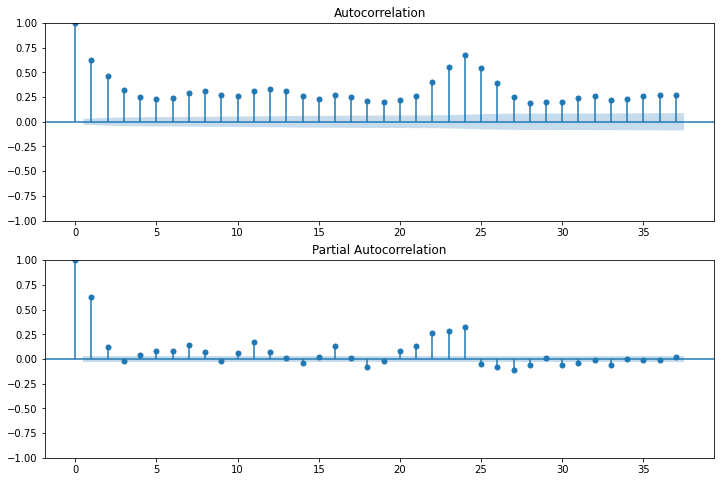

In [3]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, ax=ax2, method='ywm')

- График частичной аквтокорреляции показывает, что подходящее число лагов - 2.
- Автокорреляция указывает на скользящее среднее - 4.

## Анализ

In [4]:
# добавим признаки
def make_features(data, max_lag, rolling_mean_size):
    # календарные
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    # отстающие
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # скользящее среднее    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [5]:
make_features(data, 2, 4)

In [6]:
# посмотрим в таблице
display(data['2018-03-01': '2018-04-10'])

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,86.50
...,...,...,...,...,...,...,...,...
2018-04-10 19:00:00,71,4,10,1,19,48.0,66.0,63.25
2018-04-10 20:00:00,58,4,10,1,20,71.0,48.0,68.50
2018-04-10 21:00:00,53,4,10,1,21,58.0,71.0,60.75


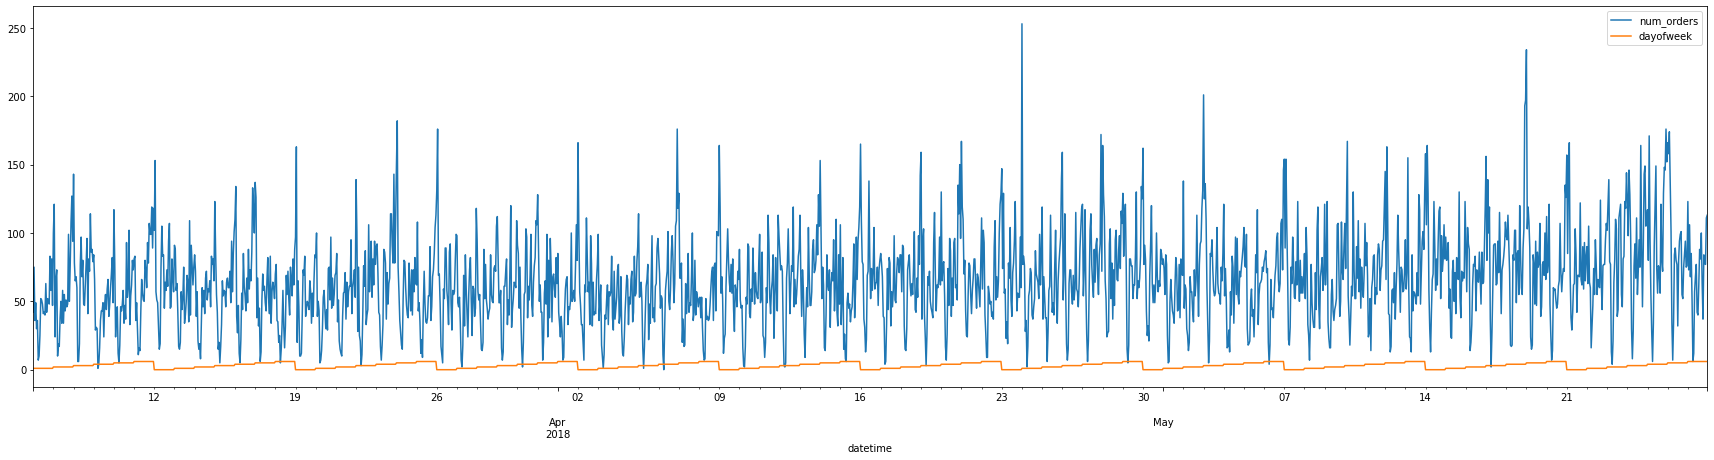

In [7]:
# посмотрим в срезе по дням недели
data[['num_orders','dayofweek']]['2018-03-06': '2018-05-27'].plot(figsize=(30,7))
plt.show()

Было предположение, что к выходным число вызовов такси заметно больше, чем в будни. Но нет такой закономерности.

Ниже видно, что в среднем больше вызовов в понедельник и пятницу.
Также рассмотрела среднее число вызовов в зависимости от часа: такси наиболее популярно в полночь, в начале и в конце рабочего дня; менее популярно в 5-7 утра

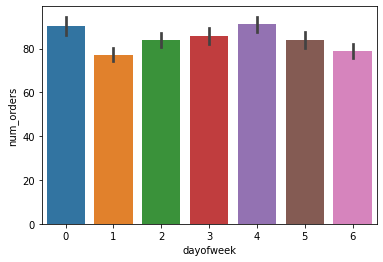

In [8]:
ax = sns.barplot(x="dayofweek", y="num_orders", data=data, estimator=np.mean)

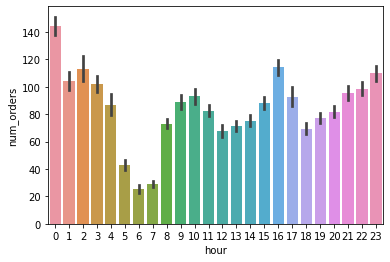

In [9]:
ax = sns.barplot(x="hour", y="num_orders", data=data, estimator=np.mean)

In [10]:
# разложим данные на составляющие
decomposed = seasonal_decompose(data['num_orders'])
dec = decomposed.trend + decomposed.seasonal + decomposed.resid

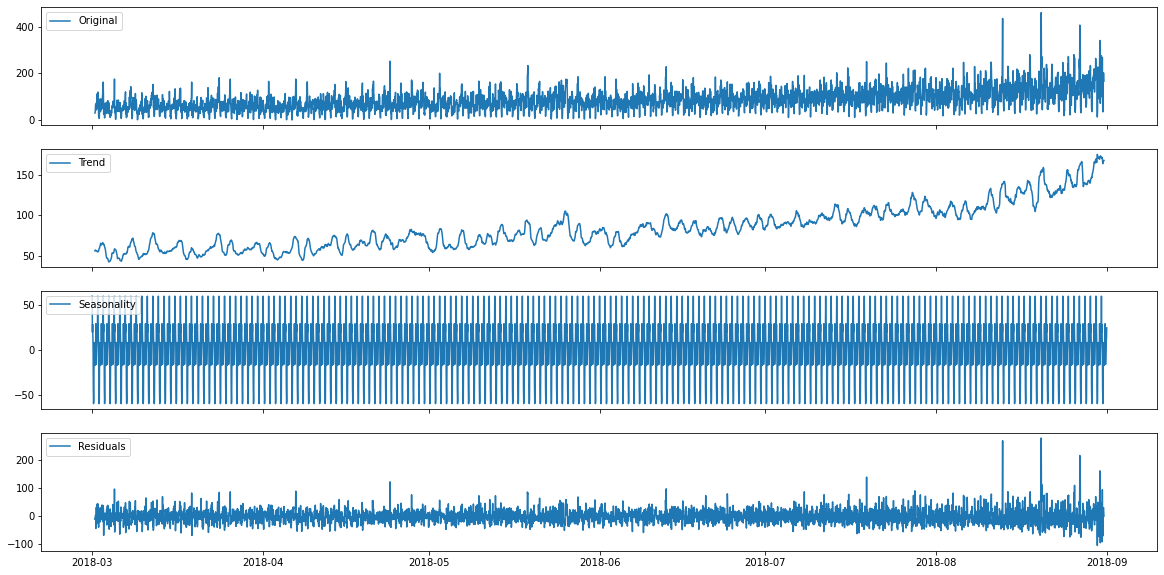

In [11]:
# визуализируем их
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(dec, label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(decomposed.trend, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(decomposed.seasonal, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(decomposed.resid, label='Residuals')
axes[3].legend(loc='upper left');

Здесь тренд показывает рост числа вызовов такси летом, особенно к концу августа. Сезонность нагляднее на срезе. Она есть, повторяется каждый день по часам

In [12]:
# разложим данные на составляющие
decomposed = seasonal_decompose(data['num_orders']['2018-03-06': '2018-04-21'])
dec = decomposed.trend + decomposed.seasonal + decomposed.resid

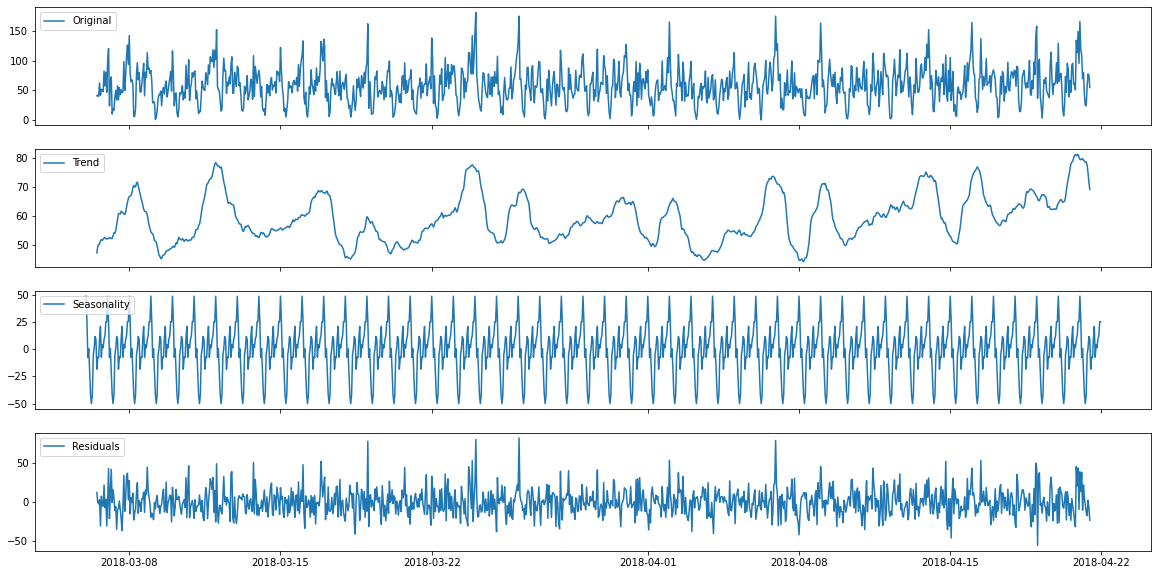

In [13]:
# визуализируем их
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)
# First plot to the Original time series
axes[0].plot(dec, label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(decomposed.trend, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(decomposed.seasonal, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(decomposed.resid, label='Residuals')
axes[3].legend(loc='upper left');

## Обучение

In [14]:
# Разобьем выборку на обучающую и тестовую
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=RND_STATE)
train = train.dropna()

In [15]:
# разделим на признаки и цели
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)

target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)

In [16]:
# проверим размерности
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

print(features_train, features_test)
print(target_train, target_test)

(3970, 7) (3970,)
(442, 7) (442,)
                     month  day  dayofweek  hour  lag_1  lag_2  rolling_mean
datetime                                                                    
2018-03-01 04:00:00      3    1          3     4   66.0   71.0         86.50
2018-03-01 05:00:00      3    1          3     5   43.0   66.0         66.25
2018-03-01 06:00:00      3    1          3     6    6.0   43.0         46.50
2018-03-01 07:00:00      3    1          3     7   12.0    6.0         31.75
2018-03-01 08:00:00      3    1          3     8   15.0   12.0         19.00
...                    ...  ...        ...   ...    ...    ...           ...
2018-08-13 09:00:00      8   13          0     9   91.0   39.0         69.75
2018-08-13 10:00:00      8   13          0    10  137.0   91.0         83.25
2018-08-13 11:00:00      8   13          0    11  156.0  137.0        105.75
2018-08-13 12:00:00      8   13          0    12  144.0  156.0        132.00
2018-08-13 13:00:00      8   13          0

Убедились, что выборка разделилась правильно

In [17]:
# Сохраним данные по времени выполнения обучения и предсказания по всем моделям
model_name = []
fit_time = []
predict_time = []
rmse_test = []

In [18]:
data.dropna(inplace=True)

def fix_time_series_rmse(model, data, column, n_splits, max_train_size, m_name):
    model_name.append(m_name)  
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)      
    f_time = 0
    p_time = 0
    RMSE = 0
    for train_index, test_index in tscv.split(data):           
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop(column, axis=1)
        train_target = train[column]
        test_features = test.drop(column, axis=1)
        test_target = test[column]
        
        start_time = time.time()
        if m_name == 'CatBoostRegressor':
            train_pool = Pool(train_features, train_target)
            model.fit(train_pool)
        else:    
            model.fit(train_features, train_target)
        f_time += round((time.time() - start_time), 4)
        
        start_time = time.time()
        predicted_valid = model.predict(test_features)
        p_time += round((time.time() - start_time), 4)
        
        RMSE += mean_squared_error(test_target, predicted_valid) ** 0.5
        
    fit_time.append(f_time / n_splits)
    predict_time.append(p_time / n_splits)
    rmse_test.append(RMSE / n_splits)

    return RMSE / n_splits

## Тестирование

In [19]:
cv_train_test_split = (train.shape[0])
cv_splits = 5

In [20]:
# Линейная регрессия
fix_time_series_rmse(model=LinearRegression(), 
                    data=train, 
                    column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split,
                    m_name='LinearRegression'   
                   )

31.395429785403792

In [21]:
%%time
# Для дерева решений подберем гиперпараметры
tscv = TimeSeriesSplit(n_splits=10)
grid = GridSearchCV(DecisionTreeRegressor(random_state=RND_STATE),
                    param_grid ={
                        "splitter":["best"],
                        "max_depth" : [3,5,7],
                        "min_samples_leaf":[1,2,3,4,5],
                        "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
                        "max_features":["log2"],
                        "max_leaf_nodes":[None,10,20,30]},
                     scoring='neg_mean_squared_error',cv=tscv
                    )

grid.fit(features_train, target_train)

CPU times: user 12.9 s, sys: 121 ms, total: 13 s
Wall time: 13 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=DecisionTreeRegressor(random_state=15),
             param_grid={'max_depth': [3, 5, 7], 'max_features': ['log2'],
                         'max_leaf_nodes': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'splitter': ['best']},
             scoring='neg_mean_squared_error')

In [22]:
# Дерево решений
fix_time_series_rmse(model=grid.best_estimator_, 
                    data=train, 
                    column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split,
                    m_name='DecisionTreeRegressor'   
                   )

35.38977304871517

In [23]:
#Lasso
fix_time_series_rmse(model=LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=RND_STATE), 
                    data=train, 
                    column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split,
                    m_name='Lasso'   
                   )

31.42083083138224

In [24]:
#Ridge
fix_time_series_rmse(model=RidgeCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10]), 
                    data=train, 
                    column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split,
                    m_name='Ridge'   
                   )

31.399781805594593

In [25]:
# CatBoostRegressor
fix_time_series_rmse(model=CatBoostRegressor(iterations=3, 
                          depth=10, 
                          learning_rate=1, 
                          loss_function='RMSE'), 
                    data=train, 
                    column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split,
                    m_name='CatBoostRegressor'   
                   )

0:	learn: 19.7080845	total: 55.9ms	remaining: 783ms
1:	learn: 16.8513889	total: 62.3ms	remaining: 405ms
2:	learn: 15.4071066	total: 69.3ms	remaining: 277ms
3:	learn: 13.9157252	total: 75.9ms	remaining: 209ms
4:	learn: 13.0208643	total: 83.3ms	remaining: 167ms
5:	learn: 12.3599567	total: 89.9ms	remaining: 135ms
6:	learn: 11.6836682	total: 96.4ms	remaining: 110ms
7:	learn: 10.6197537	total: 105ms	remaining: 91.7ms
8:	learn: 9.8929682	total: 112ms	remaining: 74.6ms
9:	learn: 9.1312125	total: 119ms	remaining: 59.6ms
10:	learn: 8.5605626	total: 126ms	remaining: 45.9ms
11:	learn: 8.2124488	total: 132ms	remaining: 32.9ms
12:	learn: 7.4308225	total: 140ms	remaining: 21.5ms
13:	learn: 7.1625712	total: 146ms	remaining: 10.4ms
14:	learn: 6.6954431	total: 152ms	remaining: 0us
0:	learn: 21.1963884	total: 7.98ms	remaining: 112ms
1:	learn: 18.5417846	total: 14.1ms	remaining: 91.4ms
2:	learn: 16.4249870	total: 21.9ms	remaining: 87.4ms
3:	learn: 15.4749523	total: 29ms	remaining: 79.7ms
4:	learn: 14.093

28.756856083443957

In [26]:
print(model_name, fit_time, predict_time, rmse_test)

['LinearRegression', 'DecisionTreeRegressor', 'Lasso', 'Ridge', 'CatBoostRegressor'] [0.00178, 0.0018599999999999999, 0.16741999999999999, 0.07792000000000002, 0.34432] [0.0012599999999999998, 0.00112, 0.0017599999999999998, 0.0018599999999999999, 0.00146] [31.395429785403792, 35.38977304871517, 31.42083083138224, 31.399781805594593, 28.756856083443957]


In [27]:
# соберем полученные списки в датафрейм
model_name_df = pd.Series(model_name).to_frame(name='model_name')
fit_time_df = pd.Series(fit_time).to_frame(name='fit_time')
predict_time_df = pd.Series(predict_time).to_frame(name='predict_time')
rmse_test_df = pd.Series(rmse_test).to_frame(name='rmse_test')

models_info = pd.concat([model_name_df, fit_time_df, predict_time_df, rmse_test_df], axis=1)
models_info.set_index('model_name', inplace=True)

In [28]:
# Сравним показатели всех отработанных моделей
display(models_info.sort_values(by='rmse_test'))

,fit_time,predict_time,rmse_test
model_name,,,
CatBoostRegressor,0.34432,0.00146,28.756856
LinearRegression,0.00178,0.00126,31.395430
Ridge,0.07792,0.00186,31.399782
Lasso,0.16742,0.00176,31.420831
DecisionTreeRegressor,0.00186,0.00112,35.389773


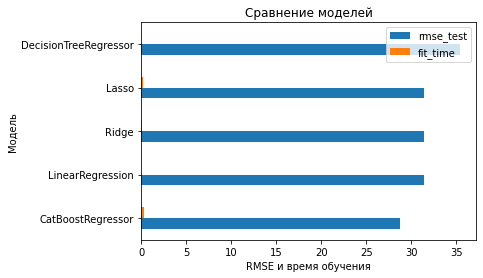

In [29]:
# сравним модели на графике
models_info[['rmse_test', 'fit_time']].sort_values(by='rmse_test').plot.barh()
plt.title('Сравнение моделей')
plt.ylabel('Модель')
plt.xlabel('RMSE и время обучения')
plt.show()

По всем показателям лучшей получилась модель CatBoostRegressor, на ней проверим тестовую выборку, подготовленную перед  обучением.

0:	learn: 25.5624125	total: 8.91ms	remaining: 125ms
1:	learn: 23.3700693	total: 17.2ms	remaining: 112ms
2:	learn: 22.3613579	total: 25.5ms	remaining: 102ms
3:	learn: 20.9051270	total: 33.3ms	remaining: 91.5ms
4:	learn: 20.5723968	total: 41.3ms	remaining: 82.5ms
5:	learn: 19.8134212	total: 49.4ms	remaining: 74ms
6:	learn: 19.4523722	total: 57.1ms	remaining: 65.2ms
7:	learn: 18.8150126	total: 65ms	remaining: 56.9ms
8:	learn: 18.0838084	total: 73.1ms	remaining: 48.7ms
9:	learn: 17.5090297	total: 82.8ms	remaining: 41.4ms
10:	learn: 17.4701283	total: 84.1ms	remaining: 30.6ms
11:	learn: 16.9057702	total: 93.1ms	remaining: 23.3ms
12:	learn: 16.2693248	total: 101ms	remaining: 15.5ms
13:	learn: 15.9759987	total: 109ms	remaining: 7.81ms
14:	learn: 15.5532839	total: 118ms	remaining: 0us
RMSE лучшей модели: 46.44924358782893
CPU times: user 150 ms, sys: 3.81 ms, total: 154 ms
Wall time: 295 ms


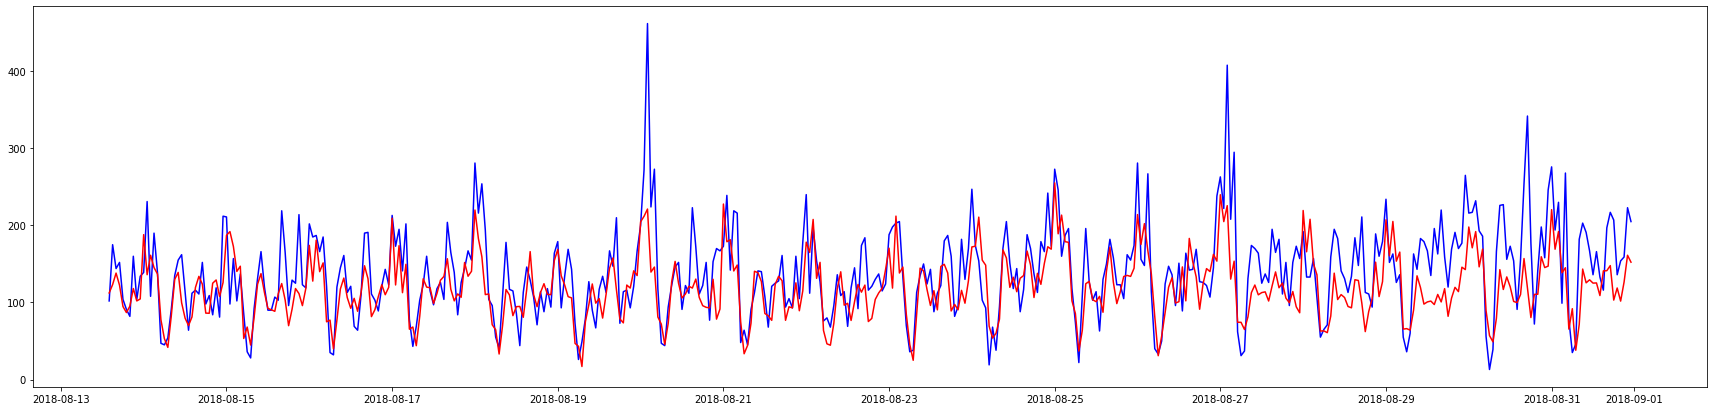

In [30]:
%%time
model = model=CatBoostRegressor(iterations=15, 
                          depth=10, 
                          learning_rate=1, 
                          loss_function='RMSE')
train_pool = Pool(features_train, target_train)
model.fit(train_pool)
predicted_test = model.predict(features_test)
rmse = mean_squared_error(target_test, predicted_test) ** 0.5
print("RMSE лучшей модели:", rmse)       

plt.figure(figsize=(30,7))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         predicted_test,
         'r-')

Предсказание близко к истине, только немного выбиваются пики.

In [31]:
# Выберу DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)

predict_test = dummy_regr.predict(features_test)
rmse = mean_squared_error(target_test, predict_test) ** 0.5
print("RMSE DummyRegressor:", rmse)    


RMSE DummyRegressor: 84.75012403274485


Видим, что полученный результат оправдывает затраченные силы. Простейшая модель и близко не стоит.

Выводы:
- мне понравилась работа, особенно доработка. После замечаний Екатерины я узнала много нового.
- воспользовалась возможностью визуализировать данные
- узнала об интересной кросс-валидации TimeSeriesSplit, дающей прекрасные результаты